In [1]:
import os
#os.environ['XLA_FLAGS'] = '--xla_cpu_enable_fast_math=false'                                     


import jax.numpy as jnp
import numpy as onp
from jax.scipy.stats import norm
from scipy.stats import norm as spnorm
from jax import jit
from jax import vmap
from jax import grad
from jax.config import config; config.update("jax_enable_x64", True)



from ml_tools.jax_kernels import ard_rbf_kernel_efficient

In [2]:
# Let's make a really simple example.
onp.random.seed(2)
x = onp.random.uniform(-2, 2, size=20).reshape(-1, 1)

In [3]:
lscale = onp.reshape(onp.random.uniform(1, 5), (1,))
alpha = 1.

k_true = ard_rbf_kernel_efficient(x, x, alpha, lscale, jitter=0)

/anaconda2/envs/jax/lib/python3.7/site-packages/jax/lib/xla_bridge.py:114: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [4]:
draw = onp.random.multivariate_normal(onp.zeros(x.shape[0]), k_true)
noise = onp.random.randn(x.shape[0]) * 0.04
y = draw + noise

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

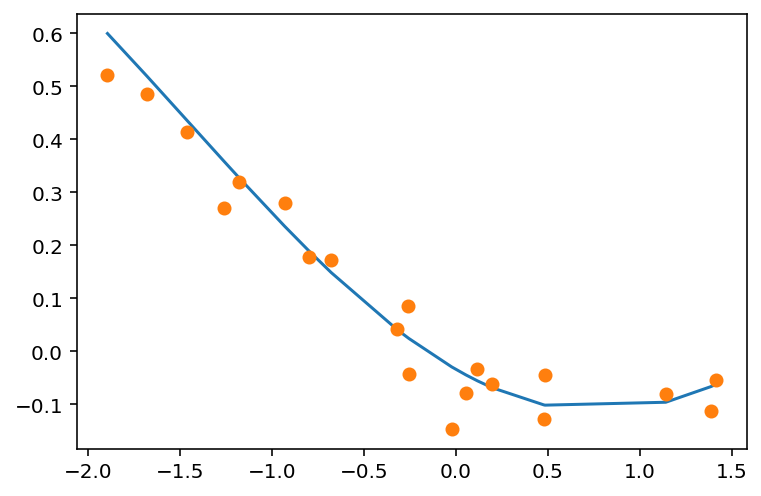

In [6]:
order = onp.argsort(x[:, 0])

plt.plot(x[order], draw[order])
plt.plot(x[order], y[order], marker='o', linestyle='none')

In [7]:
# Great. I have my input data x, and my outcomes y.

In [8]:
from svgp import get_starting_m_and_l

In [9]:
n_inducing = 20
m, L = get_starting_m_and_l(n_inducing)

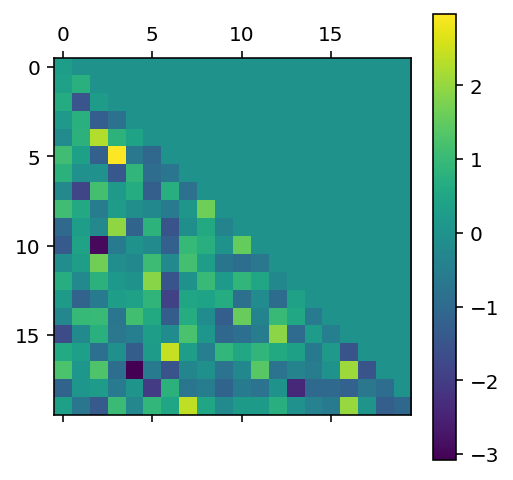

In [10]:
plt.matshow(L)
plt.colorbar()

In [11]:
Z = x

In [12]:
from svgp import compute_objective, extract_params
from likelihoods import gaussian_lik

In [13]:
from functools import partial
kern_fn = partial(ard_rbf_kernel_efficient, alpha=1., rho=jnp.array([2.]))

In [14]:
from jax import grad, jit

In [15]:
def rbf_gauss_objective(theta):
    
    m, L, kern_params = extract_params(
        theta, n_inducing, square_kern_params=True)
    
    obs_var = kern_params[0]
    
    kern_fn = partial(
        ard_rbf_kernel_efficient, alpha=kern_params[1],
        rho=kern_params[2:])
    
    cur_objective = -compute_objective(
        x, y, m, L, Z, partial(gaussian_lik, f_sd=jnp.sqrt(obs_var)), kern_fn)

    print(cur_objective)
    
    return cur_objective

def to_optimize(theta):
    
    return rbf_gauss_objective(theta), grad(rbf_gauss_objective)(theta)

In [16]:
start_vals = jnp.concatenate([
    onp.random.randn(n_inducing),
    L[onp.tril_indices_from(L)],
    jnp.reshape(0.1, (-1,)),
    jnp.reshape(alpha, (-1,)),
    jnp.reshape(lscale, (-1,))
])

In [17]:
from scipy.optimize import minimize

In [18]:
result = minimize(to_optimize, start_vals, jac=True, tol=1e-1)

8902422.22357496
Traced<ConcreteArray(8902422.22357496)>with<JVPTrace(level=1/0)>
8902422.22357496
Traced<ConcreteArray(8902422.22357496)>with<JVPTrace(level=1/0)>
7612723.009199377
Traced<ConcreteArray(7612723.009199377)>with<JVPTrace(level=1/0)>
3507821.91016674
Traced<ConcreteArray(3507821.91016674)>with<JVPTrace(level=1/0)>
601559.1388459958
Traced<ConcreteArray(601559.1388459958)>with<JVPTrace(level=1/0)>
14689709.128890675
Traced<ConcreteArray(14689709.128890675)>with<JVPTrace(level=1/0)>
166942.23205862177
Traced<ConcreteArray(166942.23205862177)>with<JVPTrace(level=1/0)>
1330876.3466373119
Traced<ConcreteArray(1330876.3466373119)>with<JVPTrace(level=1/0)>
79775.33979970838
Traced<ConcreteArray(79775.33979970838)>with<JVPTrace(level=1/0)>
85227.176563932


KeyboardInterrupt: 